In [1]:
#importing the libraries
import pandas as pd
import numpy as np
import time
import copy
import warnings
from tqdm import tqdm


#for Data preprocessing and Augmentation
import os
from imutils import paths
import cv2
# import Augmentor
import torchvision.transforms as transforms

# from sklearn.preprocessing import OneHotEncoder

#for reading and displaying images
import matplotlib.pyplot as plt
from PIL import Image

#Pytorch libraries and modules
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam, lr_scheduler
from torch.utils.data import DataLoader,Dataset
from sklearn.model_selection import train_test_split

#torchvision for pre-trained models
import torchvision
from torchvision import datasets, models

#for evaluating model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay


In [2]:
BATCH_SIZE = 32
classes = ['Normal', 'Covid']
num_classes = 2
num_epochs = 8
criterion = CrossEntropyLoss()
CHECKPOINT_PATH = '../model/FT_VGG19bn_new1.pt'
path_dataset = '/media/trucloan/Data/Research/TransferLearningVGG19bnCovid1910k_images/dataset10K_images/'

std = np.array([0.229, 0.224, 0.225])
mean = np.array([0.485, 0.456, 0.406])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [3]:
normal = path_dataset + 'NORMAL/'
covid = path_dataset + 'COVID/'

dir_normal = os.listdir(normal)
dir_covid = os.listdir(covid)


dict_data0 = {'path': normal, 'image_name': dir_normal, 'labels': 0}
dict_data1 = {'path': covid, 'image_name': dir_covid, 'labels': 1}


In [4]:
df0 = pd.DataFrame(dict_data0)
df1 = pd.DataFrame(dict_data1)
df = pd.concat([df0, df1])
df.to_csv('./data.csv', index = False)

In [5]:
train_data, test_data=train_test_split(df, test_size=0.2, random_state = 42, shuffle=True)
train_data, val_data =train_test_split(train_data, test_size=0.2, random_state = 42, shuffle=True)

In [6]:
class ImageDataset(Dataset):
    def __init__(self, csv, transform):
        self.transform = transform
        self.csv = csv
        
        self.image_name = self.csv[:]['image_name']
        self.label = np.array(self.csv[:]['labels'])
    
    def __len__(self):
        return len(self.label)
    
    def __getitem__(self, index): 
        images = Image.open(self.csv['path'].iloc[index] + self.image_name.iloc[index]).convert('RGB')
        
        images = self.transform(images)
        targets = self.label[index]
        targets = torch.tensor(targets, dtype = torch.long)
#         sample = {'image': image, 'labels': targets}
        
        return images, targets
        

In [7]:
transform = transforms.Compose([
    transforms.Grayscale(3),
    transforms.Resize((224,224)),    
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = ImageDataset(train_data, transform)
val_dataset = ImageDataset(val_data, transform)
test_dataset = ImageDataset(test_data, transform)

train_dataset

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)
test_dataloader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [9]:
def training_loop(model, optimizer, loss_list, acc_list):
    model.to(device)
    #List to store loss to visualize
    lossli = loss_list
    accli = acc_list
    
    y_true = []
    y_pred = []
    
    valid_loss_min = np.Inf # track change in validation loss
    count = 0
    patience = 3 # nếu val_loss tăng 15 lần thì ngừng
    for epoch in range(num_epochs):
        
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        train_acc = 0.0
        valid_acc = 0.0
        
        ###################
        # train the model #
        ###################
        
        model.train()
        for data, label in tqdm(train_dataloader):
            data = data.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(data)
            
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
        
            
            train_loss += loss.item()*data.size(0)
            
            _, pred = torch.max(output, 1)              
            
            train_acc += pred.eq(label).sum().item()
            
#         scheduler.step() ###########
            
        ######################
        # validate the model #
        ######################
        
        model.eval()
        with torch.no_grad():
            for data, label in tqdm(val_dataloader):
                data = data.to(device)
                label = label.to(device)
                output = model(data)
                loss = criterion(output, label)
                valid_loss += loss.item()*data.size(0)
                
                # Calculate accuracy
                _, pred = torch.max(output, 1)
#                 y_true += target.tolist()
#                 y_pred += pred.tolist()  
                
                valid_acc +=  pred.eq(label).sum().item()
       
        # calculate average losses
        train_loss = train_loss/len(train_dataloader.dataset)
        valid_loss = valid_loss/len(val_dataloader.dataset)
        lossli.append({'epoch':epoch,'train_loss': train_loss,'valid_loss':valid_loss})
        
        train_acc = train_acc*100/len(train_dataloader.dataset)
        valid_acc = valid_acc*100/len(val_dataloader.dataset)
        accli.append({'epoch':epoch,'train_acc': train_acc,'valid_acc':valid_acc})
        
        ####################
        # Early stopping #
        ##################
        
        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \n \tTraining Acc: {:.6f} \tValidation Acc: {:.6f}'.format(
            epoch, train_loss, valid_loss, train_acc, valid_acc))
        # save model if validation loss has decreased
       
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_acc': accli,
            'loss_list': lossli,
            'loss': loss
            }, CHECKPOINT_PATH)
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model ...'.format(
                valid_loss_min,
                valid_loss))
            
            count = 0
            print('count = ',count)
            torch.save(model, '../model/FTVGG19bn_new1_model.pt') #save model 
                                  
            valid_loss_min = valid_loss
        else:
            count += 1
            print('count = ',count)
            if count >= patience:
                print('Early stopping!')
   
                return lossli, accli    
           
    return lossli, accli

In [10]:
def set_parameter_requires_grad (model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
def initialize_model(num_classes, feature_extract, use_pretrained = True):
    model_ft = models.vgg19_bn(pretrained = use_pretrained)
    set_parameter_requires_grad(model_ft, feature_extract)
    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    input_size = 224
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(num_classes, feature_extract, use_pretrained = True)

print (model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [12]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = Adam(params_to_update ,lr = 0.001, weight_decay=1e-5)


Params to learn:
	 features.0.weight
	 features.0.bias
	 features.1.weight
	 features.1.bias
	 features.3.weight
	 features.3.bias
	 features.4.weight
	 features.4.bias
	 features.7.weight
	 features.7.bias
	 features.8.weight
	 features.8.bias
	 features.10.weight
	 features.10.bias
	 features.11.weight
	 features.11.bias
	 features.14.weight
	 features.14.bias
	 features.15.weight
	 features.15.bias
	 features.17.weight
	 features.17.bias
	 features.18.weight
	 features.18.bias
	 features.20.weight
	 features.20.bias
	 features.21.weight
	 features.21.bias
	 features.23.weight
	 features.23.bias
	 features.24.weight
	 features.24.bias
	 features.27.weight
	 features.27.bias
	 features.28.weight
	 features.28.bias
	 features.30.weight
	 features.30.bias
	 features.31.weight
	 features.31.bias
	 features.33.weight
	 features.33.bias
	 features.34.weight
	 features.34.bias
	 features.36.weight
	 features.36.bias
	 features.37.weight
	 features.37.bias
	 features.40.weight
	 features.40.

In [13]:
loss_list, acc_list = [],[]

since = time.time()

loss, acc = training_loop(
    model = model_ft,
    optimizer = optimizer,
    loss_list = loss_list,
    acc_list = acc_list
)
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


Epoch: 0 	Training Loss: 0.349303 	Validation Loss: 0.240521 
 	Training Acc: 87.734375 	Validation Acc: 91.437500
Validation loss decreased (inf --> 0.240521). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.51it/s]


Epoch: 1 	Training Loss: 0.226319 	Validation Loss: 0.201103 
 	Training Acc: 91.328125 	Validation Acc: 93.125000
Validation loss decreased (0.240521 --> 0.201103). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 2 	Training Loss: 0.170394 	Validation Loss: 0.307640 
 	Training Acc: 93.750000 	Validation Acc: 88.750000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 3 	Training Loss: 0.167847 	Validation Loss: 0.247032 
 	Training Acc: 93.734375 	Validation Acc: 93.125000


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 4 	Training Loss: 0.136663 	Validation Loss: 0.119788 
 	Training Acc: 95.250000 	Validation Acc: 95.250000
Validation loss decreased (0.201103 --> 0.119788). Saving model ...
count =  0


100%|██████████| 50/50 [00:33<00:00,  1.50it/s]


Epoch: 5 	Training Loss: 0.114042 	Validation Loss: 0.134322 
 	Training Acc: 96.078125 	Validation Acc: 95.687500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  1


100%|██████████| 50/50 [00:33<00:00,  1.49it/s]


Epoch: 6 	Training Loss: 0.095027 	Validation Loss: 0.201070 
 	Training Acc: 96.562500 	Validation Acc: 94.687500


  0%|          | 0/200 [00:00<?, ?it/s]

count =  2


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]


Epoch: 7 	Training Loss: 0.107068 	Validation Loss: 0.154773 
 	Training Acc: 96.015625 	Validation Acc: 96.187500
count =  3
Early stopping!
Training complete in 27m 27s


In [14]:
checkpoint = torch.load(CHECKPOINT_PATH)#, map_location=device)
model_ft.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss_list = checkpoint['loss_list']
acc_list = checkpoint['train_acc']


/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


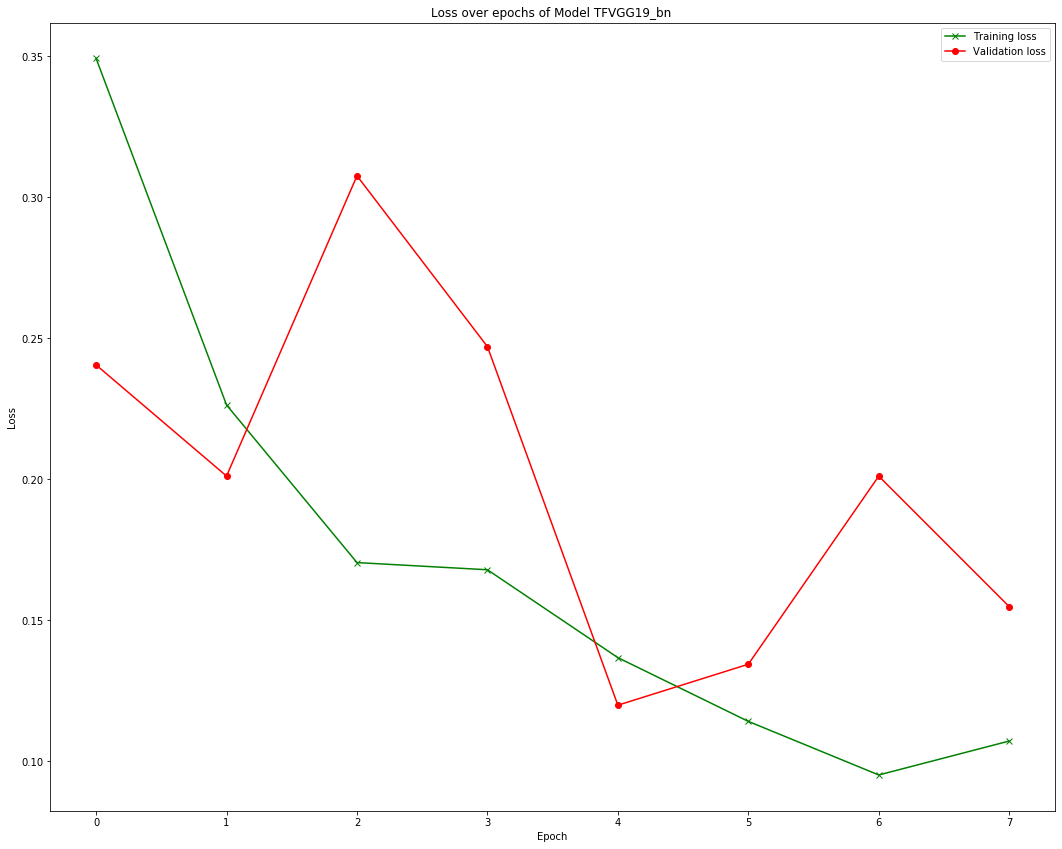

In [15]:
#ve do thi loss (train, val)
def visualize_loss (checkpoint, path_loss):
    loss = checkpoint['loss_list'] 
    train_loss = [x['train_loss'] for x in loss]
    valid_loss = [x['valid_loss'] for x in loss]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_loss, '-gx', label='Training loss')
    ax.plot(valid_loss , '-ro', label='Validation loss')
    ax.set(title="Loss over epochs of Model TFVGG19_bn ",
    xlabel='Epoch',
    ylabel='Loss')
    ax.legend()
    fig.show()
    plt.savefig(path_loss)
visualize_loss(checkpoint, '../report/FTVGG19bn/lossTFVGG19_bn.png')

/home/trucloan/anaconda3/envs/me/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


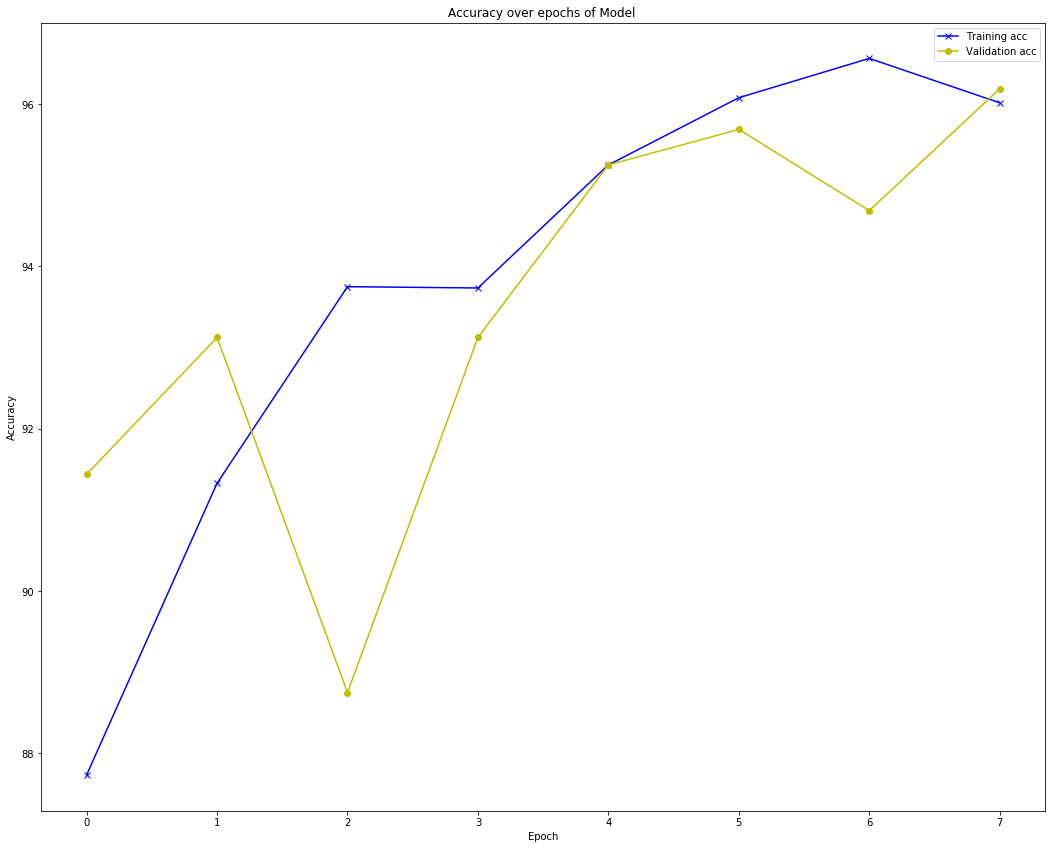

In [16]:
#ve do thi acc (train, val)
def visualize_acc (checkpoint, path_acc):
    acclist = checkpoint['train_acc'] #
    train_acc = [x['train_acc'] for x in acclist]
    valid_acc = [x['valid_acc'] for x in acclist]
    fig, ax = plt.subplots(figsize = (18, 14.5))
    ax.plot(train_acc, '-bx', label='Training acc')
    ax.plot(valid_acc , '-yo', label='Validation acc')
    ax.set(title="Accuracy over epochs of Model ",
    xlabel='Epoch',
    ylabel='Accuracy')
    ax.legend()
    fig.show()
    plt.savefig(path_acc)
visualize_acc(checkpoint, '../report/FTVGG19bn/AccuracyFTVGG19bn.png')

In [17]:
#test model
def test_loop():
    with torch.no_grad():
        y_true = []
        y_pred = []
        model_ft.to(device)
        model_ft.eval()
        for data, target in test_dataloader:
            batch_size = data.size(0)
            data = data.to(device)
            target = target.to(device)
            output = model_ft(data)
            _,pred = torch.max(output, 1)
            y_true += target.tolist()
            y_pred += pred.tolist()
    return y_true, y_pred


y_true, y_pred = test_loop()
        

In [18]:
accuracy = accuracy_score(y_true, y_pred)
accuracy

0.9635

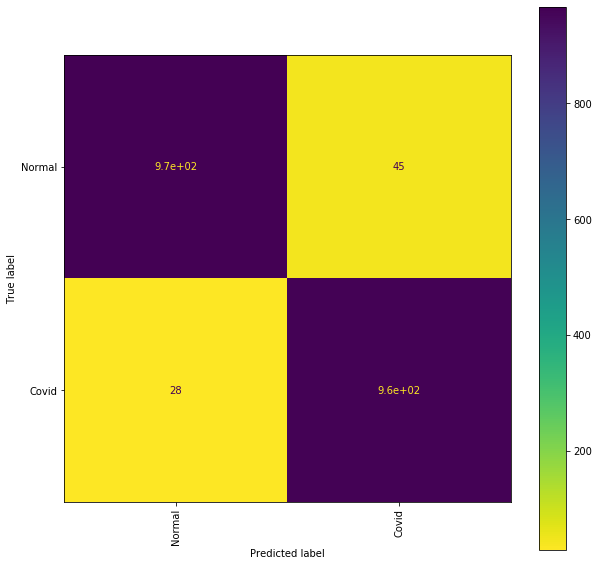

In [28]:
cnf_matrix = confusion_matrix(y_true, y_pred)
fix, ax = plt.subplots(figsize = (10,10))
disp = ConfusionMatrixDisplay(confusion_matrix = cnf_matrix, display_labels = classes)
disp.plot(include_values = True, cmap = 'viridis_r', ax = ax, xticks_rotation = 'vertical')
plt.savefig('../report/FTVGG19bn/MatrixFTVGG19bn.png')


In [27]:
print(cnf_matrix)

TP = cnf_matrix[0,0]
FN = cnf_matrix[0,1]
FP = cnf_matrix[1,0]
TN = cnf_matrix[1,1]

print(TP, FN,FP,TN)

[[967  45]
 [ 28 960]]
967 45 28 960


In [30]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = (2*TP)/(2*TP+FP+FN)
accuracy = (TP+TN)/(TP+TN+FP+FN)
specificity = TN/(TN+FP)

print(precision, recall, f1_score, accuracy, specificity)

0.9718592964824121 0.9555335968379447 0.9636273044344793 0.9635 0.97165991902834


In [20]:
path_rp = '../report/FTVGG19bn/report_FTVGG19bn2224.txt'
try:
    s = classification_report(y_true, y_pred, target_names = classes)
    with open(path_rp, mode ='x') as f:
        f.write(s)
    with open(path_rp) as f:
        print(f.read())
    f.close()
except FileExistsError:
    pass

# s = classification_report(y_true, y_pred, target_names = classes, output_dict = True)
# s

              precision    recall  f1-score   support

      Normal       0.97      0.96      0.96      1012
       Covid       0.96      0.97      0.96       988

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [21]:
def classification_report(
    y_true,
    y_pred,
    *,
    labels=None,
    target_names=None,
    sample_weight=None,
    digits=2,
    output_dict=False,
    zero_division="warn",
):
    """Build a text report showing the main classification metrics.
    Read more in the :ref:`User Guide <classification_report>`.
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Estimated targets as returned by a classifier.
    labels : array-like of shape (n_labels,), default=None
        Optional list of label indices to include in the report.
    target_names : list of str of shape (n_labels,), default=None
        Optional display names matching the labels (same order).
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    digits : int, default=2
        Number of digits for formatting output floating point values.
        When ``output_dict`` is ``True``, this will be ignored and the
        returned values will not be rounded.
    output_dict : bool, default=False
        If True, return output as dict.
        .. versionadded:: 0.20
    zero_division : "warn", 0 or 1, default="warn"
        Sets the value to return when there is a zero division. If set to
        "warn", this acts as 0, but warnings are also raised.
    Returns
    -------
    report : str or dict
        Text summary of the precision, recall, F1 score for each class.
        Dictionary returned if output_dict is True. Dictionary has the
        following structure::
            {'label 1': {'precision':0.5,
                         'recall':1.0,
                         'f1-score':0.67,
                         'support':1},
             'label 2': { ... },
              ...
            }
        The reported averages include macro average (averaging the unweighted
        mean per label), weighted average (averaging the support-weighted mean
        per label), and sample average (only for multilabel classification).
        Micro average (averaging the total true positives, false negatives and
        false positives) is only shown for multi-label or multi-class
        with a subset of classes, because it corresponds to accuracy
        otherwise and would be the same for all metrics.
        See also :func:`precision_recall_fscore_support` for more details
        on averages.
        Note that in binary classification, recall of the positive class
        is also known as "sensitivity"; recall of the negative class is
        "specificity".
    See Also
    --------
    precision_recall_fscore_support, confusion_matrix,
    multilabel_confusion_matrix
    Examples
    --------
    >>> from sklearn.metrics import classification_report
    >>> y_true = [0, 1, 2, 2, 2]
    >>> y_pred = [0, 0, 2, 2, 1]
    >>> target_names = ['class 0', 'class 1', 'class 2']
    >>> print(classification_report(y_true, y_pred, target_names=target_names))
                  precision    recall  f1-score   support
    <BLANKLINE>
         class 0       0.50      1.00      0.67         1
         class 1       0.00      0.00      0.00         1
         class 2       1.00      0.67      0.80         3
    <BLANKLINE>
        accuracy                           0.60         5
       macro avg       0.50      0.56      0.49         5
    weighted avg       0.70      0.60      0.61         5
    <BLANKLINE>
    >>> y_pred = [1, 1, 0]
    >>> y_true = [1, 1, 1]
    >>> print(classification_report(y_true, y_pred, labels=[1, 2, 3]))
                  precision    recall  f1-score   support
    <BLANKLINE>
               1       1.00      0.67      0.80         3
               2       0.00      0.00      0.00         0
               3       0.00      0.00      0.00         0
    <BLANKLINE>
       micro avg       1.00      0.67      0.80         3
       macro avg       0.33      0.22      0.27         3
    weighted avg       1.00      0.67      0.80         3
    <BLANKLINE>
    """

    y_type, y_true, y_pred = _check_targets(y_true, y_pred)

    if labels is None:
        labels = unique_labels(y_true, y_pred)
        labels_given = False
    else:
        labels = np.asarray(labels)
        labels_given = True

    # labelled micro average
    micro_is_accuracy = (y_type == "multiclass" or y_type == "binary") and (
        not labels_given or (set(labels) == set(unique_labels(y_true, y_pred)))
    )

    if target_names is not None and len(labels) != len(target_names):
        if labels_given:
            warnings.warn(
                "labels size, {0}, does not match size of target_names, {1}".format(
                    len(labels), len(target_names)
                )
            )
        else:
            raise ValueError(
                "Number of classes, {0}, does not match size of "
                "target_names, {1}. Try specifying the labels "
                "parameter".format(len(labels), len(target_names))
            )
    if target_names is None:
        target_names = ["%s" % l for l in labels]

    headers = ["precision", "recall", "f1-score", "support"]
    # compute per-class results without averaging
    p, r, f1, s = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=labels,
        average=None,
        sample_weight=sample_weight,
        zero_division=zero_division,
    )
    rows = zip(target_names, p, r, f1, s)

    if y_type.startswith("multilabel"):
        average_options = ("micro", "macro", "weighted", "samples")
    else:
        average_options = ("micro", "macro", "weighted")

    if output_dict:
        report_dict = {label[0]: label[1:] for label in rows}
        for label, scores in report_dict.items():
            report_dict[label] = dict(zip(headers, [i.item() for i in scores]))
    else:
        longest_last_line_heading = "weighted avg"
        name_width = max(len(cn) for cn in target_names)
        width = max(name_width, len(longest_last_line_heading), digits)
        head_fmt = "{:>{width}s} " + " {:>9}" * len(headers)
        report = head_fmt.format("", *headers, width=width)
        report += "\n\n"
        row_fmt = "{:>{width}s} " + " {:>9.{digits}f}" * 3 + " {:>9}\n"
        for row in rows:
            report += row_fmt.format(*row, width=width, digits=digits)
        report += "\n"

    # compute all applicable averages
    for average in average_options:
        if average.startswith("micro") and micro_is_accuracy:
            line_heading = "accuracy"
        else:
            line_heading = average + " avg"

        # compute averages with specified averaging method
        avg_p, avg_r, avg_f1, _ = precision_recall_fscore_support(
            y_true,
            y_pred,
            labels=labels,
            average=average,
            sample_weight=sample_weight,
            zero_division=zero_division,
        )
        avg = [avg_p, avg_r, avg_f1, np.sum(s)]

        if output_dict:
            report_dict[line_heading] = dict(zip(headers, [i.item() for i in avg]))
        else:
            if line_heading == "accuracy":
                row_fmt_accuracy = (
                    "{:>{width}s} "
                    + " {:>9.{digits}}" * 2
                    + " {:>9.{digits}f}"
                    + " {:>9}\n"
                )
                report += row_fmt_accuracy.format(
                    line_heading, "", "", *avg[2:], width=width, digits=digits
                )
            else:
                report += row_fmt.format(line_heading, *avg, width=width, digits=digits)

    if output_dict:
        if "accuracy" in report_dict.keys():
            report_dict["accuracy"] = report_dict["accuracy"]["precision"]
        return report_dict
    else:
        return report

In [22]:
# Predict images
def img_transform(path_img):
    img = Image.open(path_img)
    imagetensor = transform(img).cuda()
    return imagetensor

def predict(path_img, verbose = False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        pass
    model_ft.eval()
    if verbose:
        print('Model loader ...')
    image = img_transform(path_img)
    image1 = image[None,:,:,:]
    
    with torch.no_grad():
        outputs = model_ft(image1)
        
        _,pred_int = torch.max(outputs.data, 1)
        _,top1_idx = torch.topk(outputs.data, 1, dim = 1)
        pred_idx = int(pred_int.cpu().numpy())
        if pred_idx == 0:
            pred_str = str('Negative')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
        else:
            pred_str = str('Positive')
            print('img: {} is: {}'.format(os.path.basename(path_img), pred_str))
            
    

img: covid.jpg is: Positive


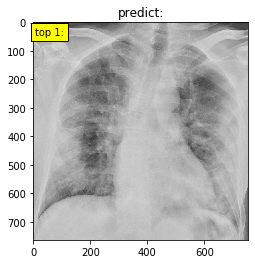

In [23]:
pred_str = str('')
path_image = '/media/trucloan/Data/Research/TransferLearningVGG19bnCovid1910k_images//pred/covid.jpg'

img = Image.open(path_image)
plt.imshow(img)

predict(path_image)
plt.title('predict:{}'.format(pred_str))
plt.text(5,45,'top {}:{}'.format(1,pred_str), bbox = dict(fc='yellow'))
plt.show()